In [1]:
# import neccessary modules
import re, shutil
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Stanford Dog Dataset

In [2]:
# Paths
STANFORD_SRC = Path("../raw/stanford-dogs-dataset/images/Images")
STANFORD_DST = Path("../processed")

# Output structure: STANFORD_DST/stanford-dogs-dataset/{train,test}/{class_name}/
STANFORD_DATASET_ROOT = STANFORD_DST / "stanford-dogs-dataset"
STANFORD_TRAIN_ROOT = STANFORD_DATASET_ROOT / "train"
STANFORD_TEST_ROOT = STANFORD_DATASET_ROOT / "test"

# Allowed image extensions
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".gif", ".webp"}

# Limits
TARGET_PER_CLASS = 100
TRAIN_COUNT_IF_ENOUGH = 80  # if >=100: 80 train, 20 test

def clean_class_name(raw_name: str) -> str:
    """
    1) Remove prefix up to first '-'
    2) Replace '-' and '_' with space
    3) Lowercase
    4) Collapse spaces (inline)
    """
    if "-" in raw_name:
        raw_name = raw_name.split("-", 1)[1]
    name = re.sub(r"[-_]+", " ", raw_name)
    name = re.sub(r"\s+", " ", name.lower()).strip()
    return name or "class"

def ensure_unique_name(dst_dir: Path, filename: str) -> str:
    """Add ' _1', ' _2', ... if file exists."""
    base = Path(filename).stem
    ext = Path(filename).suffix
    candidate = filename
    idx = 1
    while (dst_dir / candidate).exists():
        candidate = f"{base} _{idx}{ext}"
        idx += 1
    return candidate

def ensure_unique_class_name(existing_names: set, name: str) -> str:
    """Add ' -1', ' -2', ... if class name exists."""
    if name not in existing_names:
        existing_names.add(name)
        return name
    idx = 1
    candidate = f"{name} -{idx}"
    while candidate in existing_names:
        idx += 1
        candidate = f"{name} -{idx}"
    existing_names.add(candidate)
    return candidate

def is_image_file(p: Path) -> bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def main():
    STANFORD_TRAIN_ROOT.mkdir(parents=True, exist_ok=True)
    STANFORD_TEST_ROOT.mkdir(parents=True, exist_ok=True)

    if not STANFORD_SRC.exists():
        raise FileNotFoundError(f"Source not found: {STANFORD_SRC}")
    class_dirs = [d for d in STANFORD_SRC.iterdir() if d.is_dir()]
    if not class_dirs:
        print(f"No class dirs found in {STANFORD_SRC}")
        return

    used_class_names = set()
    total_classes = total_train = total_test = 0

    for cls_dir in sorted(class_dirs):
        raw_class_name = cls_dir.name
        cleaned_class_name = ensure_unique_class_name(
            used_class_names, clean_class_name(raw_class_name)
        )

        img_files = [p for p in cls_dir.iterdir() if is_image_file(p)]
        if not img_files:
            print(f"[skip] {raw_class_name} -> {cleaned_class_name}: no images")
            continue

        # Stable order by original filename
        img_files.sort(key=lambda p: p.name)

        # Pick up to 100; else take all; split 80/20
        if len(img_files) >= TARGET_PER_CLASS:
            selected = img_files[:TARGET_PER_CLASS]
            train_count = TRAIN_COUNT_IF_ENOUGH
            test_count = TARGET_PER_CLASS - TRAIN_COUNT_IF_ENOUGH
        else:
            selected = img_files
            n = len(selected)
            train_count = int(round(n * 0.8))
            test_count = n - train_count

        train_dir = STANFORD_TRAIN_ROOT / cleaned_class_name
        test_dir = STANFORD_TEST_ROOT / cleaned_class_name
        train_dir.mkdir(parents=True, exist_ok=True)
        test_dir.mkdir(parents=True, exist_ok=True)

        for i, src_path in enumerate(selected):
            dst_dir = train_dir if i < train_count else test_dir
            final_name = ensure_unique_name(dst_dir, src_path.name)
            shutil.copy2(src_path, dst_dir / final_name)

        total_classes += 1
        total_train += train_count
        total_test += test_count

        print(f"[done] {raw_class_name} -> {cleaned_class_name} | "
              f"{len(selected)} imgs (train {train_count}, test {test_count})")

    print(f"Classes: {total_classes}")
    print(f"Copied: train {total_train}, test {total_test}")
    print(f"Output:\n- {STANFORD_TRAIN_ROOT}\n- {STANFORD_TEST_ROOT}")

if __name__ == "__main__":
    main()

[done] n02085620-Chihuahua -> chihuahua | 100 imgs (train 80, test 20)
[done] n02085782-Japanese_spaniel -> japanese spaniel | 100 imgs (train 80, test 20)
[done] n02085936-Maltese_dog -> maltese dog | 100 imgs (train 80, test 20)
[done] n02086079-Pekinese -> pekinese | 100 imgs (train 80, test 20)
[done] n02086240-Shih-Tzu -> shih tzu | 100 imgs (train 80, test 20)
[done] n02086646-Blenheim_spaniel -> blenheim spaniel | 100 imgs (train 80, test 20)
[done] n02086910-papillon -> papillon | 100 imgs (train 80, test 20)
[done] n02087046-toy_terrier -> toy terrier | 100 imgs (train 80, test 20)
[done] n02087394-Rhodesian_ridgeback -> rhodesian ridgeback | 100 imgs (train 80, test 20)
[done] n02088094-Afghan_hound -> afghan hound | 100 imgs (train 80, test 20)
[done] n02088238-basset -> basset | 100 imgs (train 80, test 20)
[done] n02088364-beagle -> beagle | 100 imgs (train 80, test 20)
[done] n02088466-bloodhound -> bloodhound | 100 imgs (train 80, test 20)
[done] n02088632-bluetick -> bl

In [3]:
# Get class names from processed train dir
TRAIN_ROOT = Path("../processed/stanford-dogs-dataset/train")

stanford_dog_breeds = [d.name for d in TRAIN_ROOT.iterdir() if d.is_dir()]

print(len(stanford_dog_breeds))
print(stanford_dog_breeds)

120
['eskimo dog', 'miniature pinscher', 'irish setter', 'irish terrier', 'whippet', 'standard schnauzer', 'flat coated retriever', 'scotch terrier', 'rottweiler', 'tibetan mastiff', 'dandie dinmont', 'kelpie', 'norfolk terrier', 'toy poodle', 'schipperke', 'leonberg', 'bull mastiff', 'pomeranian', 'wire haired fox terrier', 'italian greyhound', 'bernese mountain dog', 'afghan hound', 'pekinese', 'toy terrier', 'sealyham terrier', 'english springer', 'old english sheepdog', 'scottish deerhound', 'basenji', 'french bulldog', 'shih tzu', 'komondor', 'walker hound', 'basset', 'great dane', 'soft coated wheaten terrier', 'bedlington terrier', 'border terrier', 'dhole', 'curly coated retriever', 'staffordshire bullterrier', 'lhasa', 'great pyrenees', 'chihuahua', 'irish water spaniel', 'tibetan terrier', 'standard poodle', 'newfoundland', 'german short haired pointer', 'pug', 'lakeland terrier', 'cairn', 'malamute', 'brabancon griffon', 'african hunting dog', 'beagle', 'cocker spaniel', 'vi

## Synthetic Dog Breed Health Dataset

In [4]:
# Paths
SYNTHETIC_SRC = Path("../raw/synthetic_dog_breed_health_data.csv")
SYNTHETIC_DST = Path("../processed/synthetic-dog-breed-health-data-clean.csv")

synthetic_df = pd.read_csv(SYNTHETIC_SRC)

print("raw shape:", synthetic_df.shape)
synthetic_df.head()

raw shape: (10000, 21)


,ID,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,...,Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Synthetic,Healthy
0,1,Australian Shepherd,Medium,Male,3.0,60.0,Neutered,NaN,NaN,Wellness,...,No,Yes,No,12.0,1.0,Active,1.0,30.0,Yes,Yes
1,2,Dachshund,NaN,Female,4.0,57.0,Neutered,Very Active,Home cooked,Special,...,Yes,No,No,11.0,3.0,NaN,0.0,47.0,Yes,NaN
2,3,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,...,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes,Yes
3,4,Siberian Husky,Medium,Male,13.0,35.0,NaN,Very Active,NaN,Special,...,No,No,No,12.0,NaN,NaN,1.0,75.0,Yes,Yes
4,5,Boxer,Medium,Male,13.0,35.0,NaN,Very Active,Wet food,Purina,...,Yes,Yes,No,9.0,1.0,NaN,0.0,64.0,Yes,No


In [5]:
# Replace invalid values and drop rows with NA
synthetic_df = synthetic_df.replace(["", " ", "NA", "NaN", "None"], pd.NA)
synthetic_df = synthetic_df.dropna()

# Remove ID column
synthetic_df = synthetic_df.drop(columns=["ID"])

print("Shape:", synthetic_df.shape)
synthetic_df.head()

Shape: (2329, 20)


,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,Daily Walk Distance (miles),Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Synthetic,Healthy
2,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,1.0,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes,Yes
8,Australian Shepherd,Medium,Male,12.0,28.0,Neutered,Moderate,Special diet,Royal Canin,2.0,Yes,Yes,No,11.0,2.0,Moderate,0.0,65.0,Yes,No
10,Rottweiler,Large,Male,2.0,64.0,Spayed,Very Active,Hard food,Blue Buffalo,3.0,Yes,Yes,No,11.0,2.0,Active,1.0,87.0,Yes,Yes
17,Boxer,Medium,Female,2.0,46.0,Spayed,Active,Special diet,Nutro,2.0,No,Yes,No,8.0,2.0,Moderate,1.0,48.0,Yes,Yes
22,German Shepherd,Large,Female,11.0,38.0,Spayed,Very Active,Wet food,Purina,1.0,Yes,No,No,12.0,1.0,Moderate,1.0,100.0,Yes,Yes


In [6]:
# Get the common dog breeds between stanford_dog_breeds and synthetic_df['Breed']
common_breeds = set(stanford_dog_breeds).intersection(set(synthetic_df['Breed'].str.lower()))
print(f"Common breeds ({len(common_breeds)}):")
print(sorted(common_breeds))

Common breeds (11):
['beagle', 'boxer', 'chihuahua', 'doberman', 'german shepherd', 'golden retriever', 'great dane', 'labrador retriever', 'rottweiler', 'siberian husky', 'yorkshire terrier']


In [7]:
# Get the final processed dataset for synthetic dog breed health data
final_synthetic_df = synthetic_df[synthetic_df['Breed'].str.lower().isin(common_breeds)]

print("Final shape:", final_synthetic_df.shape)
final_synthetic_df.head()


Final shape: (1668, 20)


,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,Daily Walk Distance (miles),Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Synthetic,Healthy
2,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,1.0,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes,Yes
10,Rottweiler,Large,Male,2.0,64.0,Spayed,Very Active,Hard food,Blue Buffalo,3.0,Yes,Yes,No,11.0,2.0,Active,1.0,87.0,Yes,Yes
17,Boxer,Medium,Female,2.0,46.0,Spayed,Active,Special diet,Nutro,2.0,No,Yes,No,8.0,2.0,Moderate,1.0,48.0,Yes,Yes
22,German Shepherd,Large,Female,11.0,38.0,Spayed,Very Active,Wet food,Purina,1.0,Yes,No,No,12.0,1.0,Moderate,1.0,100.0,Yes,Yes
25,Chihuahua,Small,Male,10.0,15.0,Neutered,Moderate,Wet food,Wellness,3.0,No,Yes,No,8.0,3.0,Moderate,1.0,72.0,Yes,No


In [8]:
# Get the final processed dataset for stanford dog breeds
# Paths
STANFORD_BASE = Path("../processed/stanford-dogs-dataset")
STANFORD_TRAIN = STANFORD_BASE / "train"
STANFORD_TEST = STANFORD_BASE / "test"

def clean_folders(base_path: Path, allowed: set):
    for folder in base_path.iterdir():
        if folder.is_dir():
            if folder.name.lower() not in allowed:
                print(f"Removing: {folder.relative_to(base_path)}")
                shutil.rmtree(folder)

clean_folders(STANFORD_TRAIN, set(common_breeds))
clean_folders(STANFORD_TEST, set(common_breeds))

print("Cleanup done. Remaining breeds:")
print("Train:", [f.name for f in STANFORD_TRAIN.iterdir() if f.is_dir()])
print("Test:", [f.name for f in STANFORD_TEST.iterdir() if f.is_dir()])

Removing: eskimo dog
Removing: miniature pinscher
Removing: irish setter
Removing: irish terrier
Removing: whippet
Removing: standard schnauzer
Removing: flat coated retriever
Removing: scotch terrier
Removing: tibetan mastiff
Removing: dandie dinmont
Removing: kelpie
Removing: norfolk terrier
Removing: toy poodle
Removing: schipperke
Removing: leonberg
Removing: bull mastiff
Removing: pomeranian
Removing: wire haired fox terrier
Removing: italian greyhound
Removing: bernese mountain dog
Removing: afghan hound
Removing: pekinese
Removing: toy terrier
Removing: sealyham terrier
Removing: english springer
Removing: old english sheepdog
Removing: scottish deerhound
Removing: basenji
Removing: french bulldog
Removing: shih tzu
Removing: komondor
Removing: walker hound
Removing: basset
Removing: soft coated wheaten terrier
Removing: bedlington terrier
Removing: border terrier
Removing: dhole
Removing: curly coated retriever
Removing: staffordshire bullterrier
Removing: lhasa
Removing: great

## EDA for Synthetic Dog Breed Health Dataset

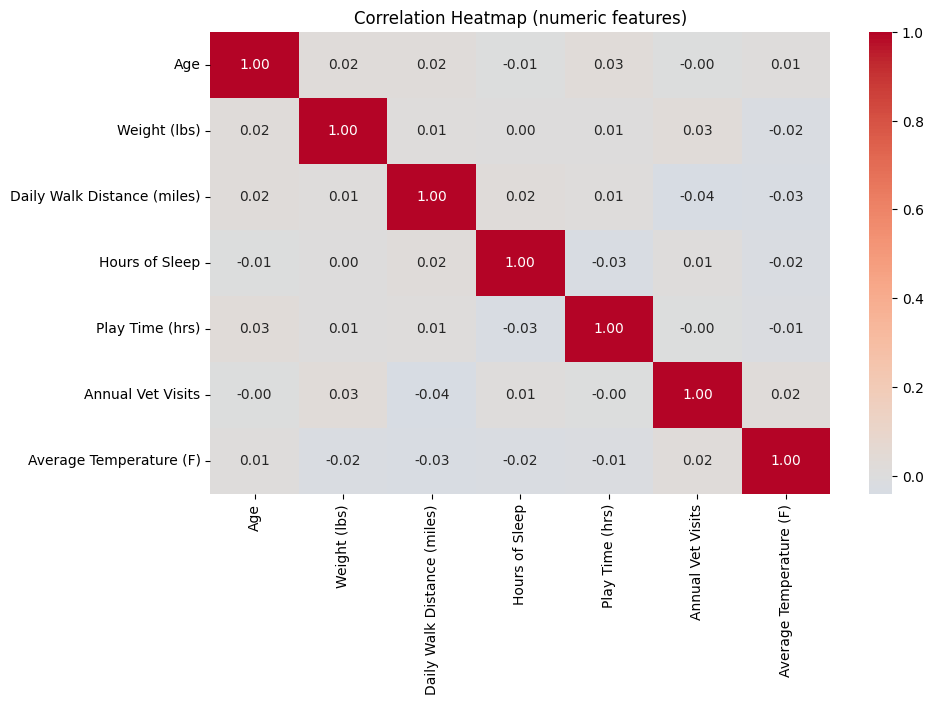

In [9]:
# Targets
# targets = ["Daily Activity Level", "Diet", "Play Time (hrs)", "Healthy"]

# Correlation heatmap for numeric columns
numeric_df = synthetic_df.select_dtypes(include="number")
plt.figure(figsize=(10,6))
sns.heatmap(
    numeric_df.corr(),
    cmap="coolwarm",
    center=0,
    annot=True,
    fmt=".2f"
)
plt.title("Correlation Heatmap (numeric features)")
plt.show()


The heatmap shows that all numeric features have very weak correlations with each other. This means there is no multicollinearity issue.

In [10]:
# Drop columns with too few or too many unique values
to_drop = [col for col in synthetic_df.columns if synthetic_df[col].nunique() <= 1]
synthetic_df = synthetic_df.drop(columns=to_drop)

synthetic_df.head()

,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Food Brand,Daily Walk Distance (miles),Other Pets in Household,Medications,Seizures,Hours of Sleep,Play Time (hrs),Owner Activity Level,Annual Vet Visits,Average Temperature (F),Healthy
2,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,Special,1.0,Yes,No,No,10.0,1.0,Low,0.0,92.0,Yes
8,Australian Shepherd,Medium,Male,12.0,28.0,Neutered,Moderate,Special diet,Royal Canin,2.0,Yes,Yes,No,11.0,2.0,Moderate,0.0,65.0,No
10,Rottweiler,Large,Male,2.0,64.0,Spayed,Very Active,Hard food,Blue Buffalo,3.0,Yes,Yes,No,11.0,2.0,Active,1.0,87.0,Yes
17,Boxer,Medium,Female,2.0,46.0,Spayed,Active,Special diet,Nutro,2.0,No,Yes,No,8.0,2.0,Moderate,1.0,48.0,Yes
22,German Shepherd,Large,Female,11.0,38.0,Spayed,Very Active,Wet food,Purina,1.0,Yes,No,No,12.0,1.0,Moderate,1.0,100.0,Yes


In addition to dropping ID and Synthetic, I believe that Food Brand, Owner Activity Level, and Other Pets in Household should also be removed. These columns provide little predictive power for our targets, Food Brand is a high-cardinality categorical feature unrelated to health or activity, Owner Activity Level is indirect and redundant given we already have direct activity features, and Other Pets in Household carries very limited information. Removing them helps simplify the dataset and reduce noise for modeling.

In [11]:
# Drop columns that are not useful for modeling
synthetic_df = synthetic_df.drop(columns=["Food Brand", "Owner Activity Level", "Other Pets in Household"], errors="ignore")
print("Final shape:", synthetic_df.shape)
synthetic_df.head()

Final shape: (2329, 16)


,Breed,Breed Size,Sex,Age,Weight (lbs),Spay/Neuter Status,Daily Activity Level,Diet,Daily Walk Distance (miles),Medications,Seizures,Hours of Sleep,Play Time (hrs),Annual Vet Visits,Average Temperature (F),Healthy
2,Chihuahua,Small,Female,12.0,67.0,Neutered,Active,Home cooked,1.0,No,No,10.0,1.0,0.0,92.0,Yes
8,Australian Shepherd,Medium,Male,12.0,28.0,Neutered,Moderate,Special diet,2.0,Yes,No,11.0,2.0,0.0,65.0,No
10,Rottweiler,Large,Male,2.0,64.0,Spayed,Very Active,Hard food,3.0,Yes,No,11.0,2.0,1.0,87.0,Yes
17,Boxer,Medium,Female,2.0,46.0,Spayed,Active,Special diet,2.0,Yes,No,8.0,2.0,1.0,48.0,Yes
22,German Shepherd,Large,Female,11.0,38.0,Spayed,Very Active,Wet food,1.0,No,No,12.0,1.0,1.0,100.0,Yes


In [12]:
# Save processed CSV
synthetic_df.to_csv(SYNTHETIC_DST, index=False)